In [50]:
import pandas as pd
import numpy as np
import pickle

import itertools
import xgboost as xgb
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

import matplotlib
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns


x_train_text = pd.read_csv('data/t2e/text_train.csv')
x_test_text = pd.read_csv('data/t2e/text_test.csv')

y_train_text = x_train_text['label']
y_test_text = x_test_text['label']

x_train_audio = pd.read_csv('data/s2e/audio_train.csv')
x_test_audio = pd.read_csv('data/s2e/audio_test.csv')


y_train_audio = x_train_audio['label']
y_test_audio = x_test_audio['label']

y_train = y_train_audio  # since y_train_audio == y_train_text
y_test = y_test_audio  # since y_train_audio == y_train_text

print(x_train_text.shape, y_train_text.shape, x_train_audio.shape, y_train_audio.shape)

(1121, 3) (1121,) (1121, 11) (1121,)


In [51]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])

id_to_emotion = {0: 'ang', 1: 'hap', 2: 'sad', 3: 'fea', 4: 'sur', 5: 'neu'}

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

In [52]:
cl_weight = dict(pd.Series(x_train_audio['label']).value_counts(normalize=True))

## Get Text Features

In [53]:
# Gabungkan data teks pelatihan dan pengujian dengan reset index agar aman
combined_text = pd.concat([x_train_text, x_test_text], ignore_index=True)

# Pastikan kolom 'transcription' ada
if 'transcription' not in combined_text.columns:
    raise KeyError("Kolom 'transcription' tidak ditemukan di data teks.")

# Inisialisasi TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    sublinear_tf=True,
    min_df=5,
    norm='l2',
    encoding='latin-1',
    ngram_range=(1, 2),
    stop_words='english'
)

# Fit dan transformasi pada data gabungan
features_text = tfidf.fit_transform(combined_text['transcription']).toarray()

# Pisahkan kembali fitur ke data pelatihan dan pengujian
x_train_text_features = features_text[:x_train_text.shape[0]]
x_test_text_features = features_text[x_train_text.shape[0]:]

print(features_text.shape, x_train_text_features.shape, x_test_text_features.shape)


(1402, 258) (1121, 258) (281, 258)


In [54]:
# Menampilkan 5 baris pertama data training
print("Sample data training (5 baris pertama):")
print(x_train_text_features[:5])

# Menampilkan 5 baris pertama data testing
print("\nSample data testing (5 baris pertama):")
print(x_test_text_features[:5])


Sample data training (5 baris pertama):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Sample data testing (5 baris pertama):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Combine Text + Audio Features

In [55]:
combined_x_train = np.concatenate((np.array(x_train_audio[x_train_audio.columns[2:]]), x_train_text_features), axis=1)
combined_x_test = np.concatenate((np.array(x_test_audio[x_test_audio.columns[2:]]), x_test_text_features), axis=1)

print(combined_x_train.shape, combined_x_test.shape)

combined_features_dict = {}

combined_features_dict['x_train'] = combined_x_train
combined_features_dict['x_test'] = combined_x_test
combined_features_dict['y_train'] = np.array(y_train)
combined_features_dict['y_test'] = np.array(y_test)

with open('data/combined/combined_features.pkl', 'wb') as f:
    pickle.dump(combined_features_dict, f)

(1121, 267) (281, 267)


In [56]:
# Menampilkan 5 baris pertama data training
print("Sample data training (5 baris pertama):")
print(combined_x_train[:5])

# Menampilkan 5 baris pertama data testing
print("\nSample data testing (5 baris pertama):")
print(combined_x_test[:5])


Sample data training (5 baris pertama):
[[2.         0.00662844 0.01313909 ... 0.         0.         0.        ]
 [2.         0.01035075 0.01582326 ... 0.         0.         0.        ]
 [1.         0.06140922 0.07574686 ... 0.         0.         0.        ]
 [1.         0.06254405 0.07924651 ... 0.         0.         0.        ]
 [0.         0.07451186 0.08908612 ... 0.         0.         0.        ]]

Sample data testing (5 baris pertama):
[[1.         0.03444014 0.04951907 ... 0.         0.         0.        ]
 [5.         0.04376725 0.05266075 ... 0.         0.         0.        ]
 [5.         0.00945359 0.01439537 ... 0.         0.         0.        ]
 [5.         0.02765756 0.0418439  ... 0.         0.         0.        ]
 [5.         0.02476407 0.03261737 ... 0.         0.         0.        ]]


Test Set Accuracy =  0.883
Test Set F-score =  0.594
Test Set Precision =  0.606
Test Set Recall =  0.594
Confusion matrix, without normalization
[[31  6  7  0  0  0]
 [ 0 52  5  0  0  0]
 [ 0  4 93  0  0  0]
 [ 0  0  4  0  0  0]
 [ 0  1  5  0  0  0]
 [ 0  0  1  0  0 72]]


c:\Users\Unity_Comp\anaconda3\envs\cudaRun\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


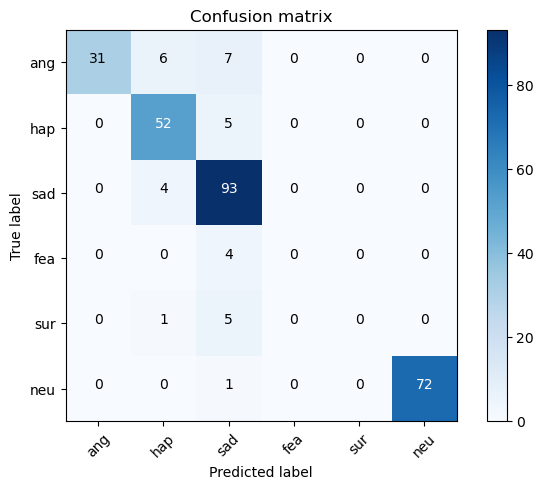

In [57]:
rf_classifier = RandomForestClassifier(n_estimators=600, min_samples_split=25)
rf_classifier.fit(combined_x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(combined_x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/combined_rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

with open('trained_models/combined/RF.pkl', 'wb') as f:
    pickle.dump(rf_classifier, f)

c:\Users\Unity_Comp\anaconda3\envs\cudaRun\lib\site-packages\xgboost\training.py:183: UserWarning: [04:03:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[44  0  0  0  0  0]
 [ 0 57  0  0  0  0]
 [ 0  0 97  0  0  0]
 [ 0  0  0  4  0  0]
 [ 0  0  0  0  6  0]
 [ 0  0  0  0  0 73]]


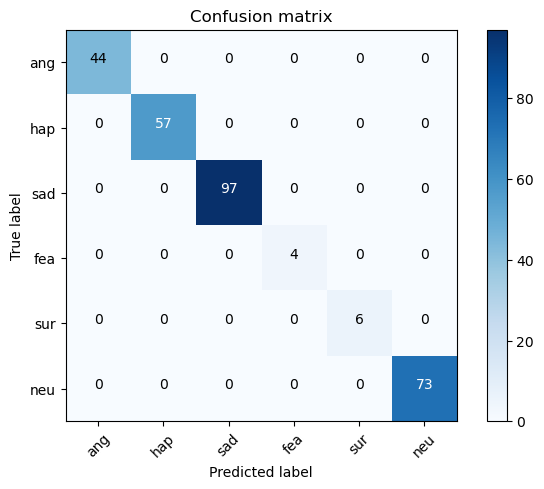

In [58]:
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                   n_estimators=600, sub_sample=0.8, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(combined_x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(combined_x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/combined_xgb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

with open('trained_models/combined/XGB.pkl', 'wb') as f:
    pickle.dump(xgb_classifier, f)

Test Set Accuracy =  0.851
Test Set F-score =  0.582
Test Set Precision =  0.577
Test Set Recall =  0.589
Confusion matrix, without normalization
[[44  0  0  0  0  0]
 [ 1 38 18  0  0  0]
 [ 0 12 84  0  1  0]
 [ 0  0  4  0  0  0]
 [ 0  0  2  0  0  4]
 [ 0  0  0  0  0 73]]


c:\Users\Unity_Comp\anaconda3\envs\cudaRun\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


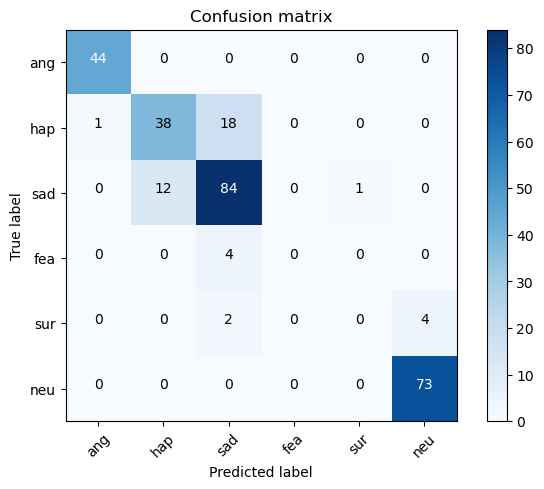

In [59]:
svc_classifier = LinearSVC()

svc_classifier.fit(combined_x_train, y_train)

# Predict
pred = svc_classifier.predict(combined_x_test)

# Results
one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)
(y_test, pred_probs)

with open('pred_probas/combined_svc_classifier_model.pkl', 'wb') as f:
    pickle.dump(svc_classifier, f)
    
with open('trained_models/combined/SVC.pkl', 'wb') as f:
    pickle.dump(svc_classifier, f)

Test Set Accuracy =  0.737
Test Set F-score =  0.503
Test Set Precision =  0.527
Test Set Recall =  0.500
Confusion matrix, without normalization
[[33  6  5  0  0  0]
 [ 0 31 22  0  0  4]
 [ 0  2 75  0  0 20]
 [ 0  0  1  0  0  3]
 [ 0  0  3  0  0  3]
 [ 0  0  5  0  0 68]]


c:\Users\Unity_Comp\anaconda3\envs\cudaRun\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


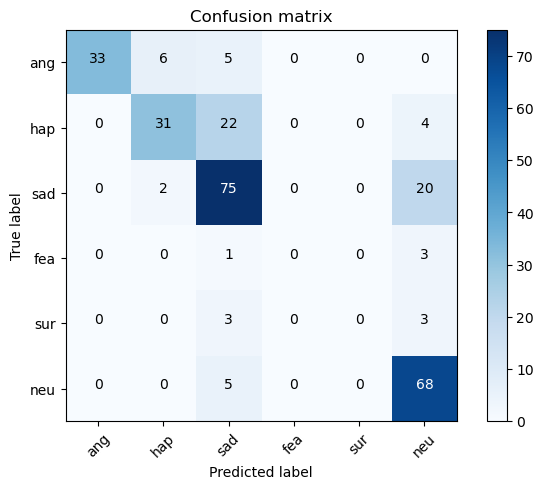

In [60]:
mnb_classifier = MultinomialNB()

mnb_classifier.fit(combined_x_train, y_train)

# Predict
pred_probs = mnb_classifier.predict_proba(combined_x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/combined_mnb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
    
with open('trained_models/combined/MNB.pkl', 'wb') as f:
    pickle.dump(mnb_classifier, f)

Test Set Accuracy =  0.964
Test Set F-score =  0.798
Test Set Precision =  0.805
Test Set Recall =  0.798
Confusion matrix, without normalization
[[44  0  0  0  0  0]
 [ 0 57  0  0  0  0]
 [ 0  1 94  2  0  0]
 [ 0  0  1  2  1  0]
 [ 0  0  0  1  2  3]
 [ 0  0  0  0  1 72]]


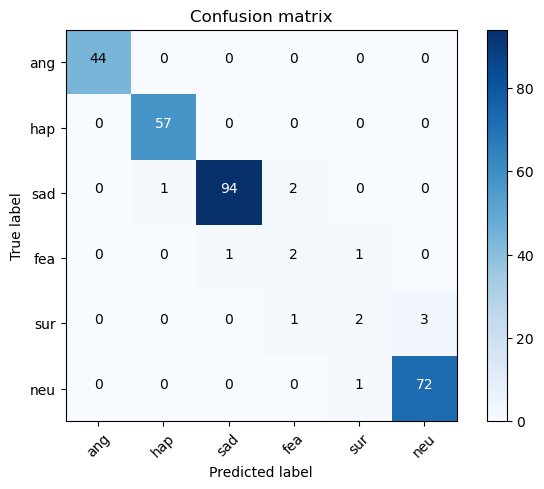

In [61]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.01,
                               power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.0001,
                               verbose=False, warm_start=True, momentum=0.8, nesterovs_momentum=True,
                               early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                               epsilon=1e-08)

mlp_classifier.fit(combined_x_train, y_train)

# Predict
pred_probs = mlp_classifier.predict_proba(combined_x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/combined_mlp_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
    
with open('trained_models/combined/MLP.pkl', 'wb') as f:
    pickle.dump(mlp_classifier, f)

c:\Users\Unity_Comp\anaconda3\envs\cudaRun\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Unity_Comp\anaconda3\envs\cudaRun\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Set Accuracy =  0.964
Test Set F-score =  0.657
Test Set Precision =  0.647
Test Set Recall =  0.667
Confusion matrix, without normalization
[[44  0  0  0  0  0]
 [ 0 57  0  0  0  0]
 [ 0  0 97  0  0  0]
 [ 0  0  4  0  0  0]
 [ 0  0  0  0  0  6]
 [ 0  0  0  0  0 73]]


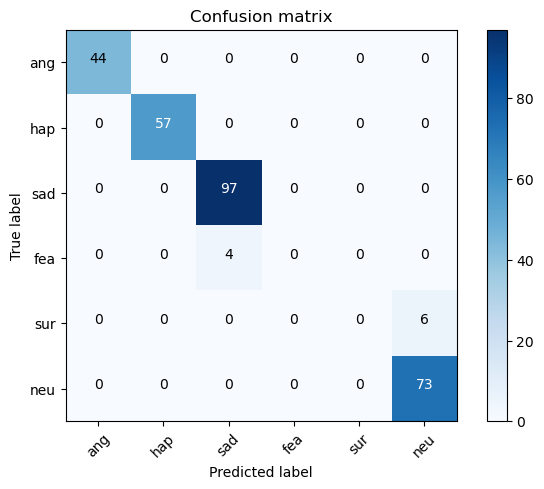

In [62]:
lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)

lr_classifier.fit(combined_x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(combined_x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/combined_lr_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
    
with open('trained_models/combined/LR.pkl', 'wb') as f:
    pickle.dump(lr_classifier, f)

[0.6981577  0.00137826 0.00948143 0.00487331 0.00882601 0.00211951
 0.01252294 0.         0.0152986  0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.01109432
 0.         0.         0.         0.         0.         0.
 0.         0.06328851 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.03883525
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.03469281 0.01245062 0.
 0.         0.01784986 0.         0.         0.         0.
 0.         0.         0.       

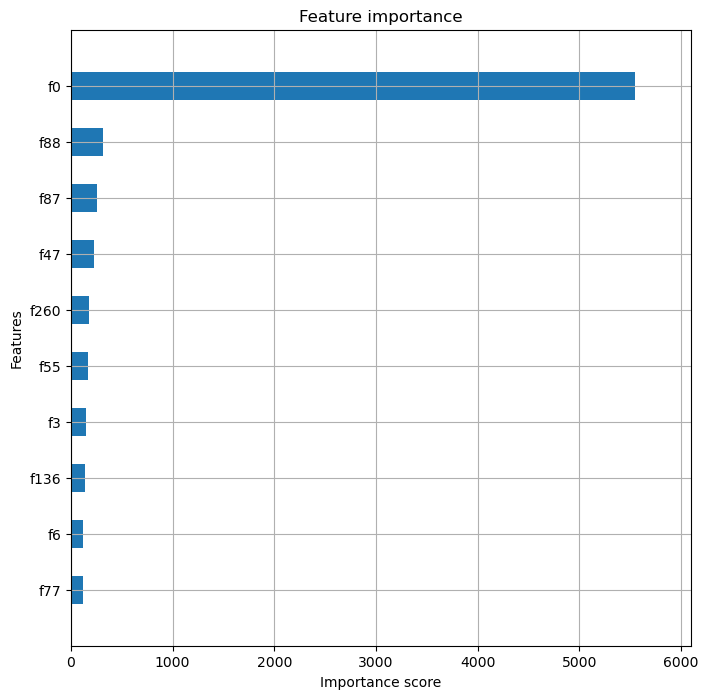

In [63]:
ax = xgb.plot_importance(xgb_classifier, max_num_features=10, height=0.5, show_values=False)
fig = ax.figure
fig.set_size_inches(8, 8)
contribution_scores = xgb_classifier.feature_importances_
print(contribution_scores)

Test Set Accuracy =  0.975
Test Set F-score =  0.771
Test Set Precision =  0.820
Test Set Recall =  0.750
Confusion matrix, without normalization
[[44  0  0  0  0  0]
 [ 0 57  0  0  0  0]
 [ 0  0 97  0  0  0]
 [ 0  0  4  0  0  0]
 [ 0  0  0  0  3  3]
 [ 0  0  0  0  0 73]]


c:\Users\Unity_Comp\anaconda3\envs\cudaRun\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


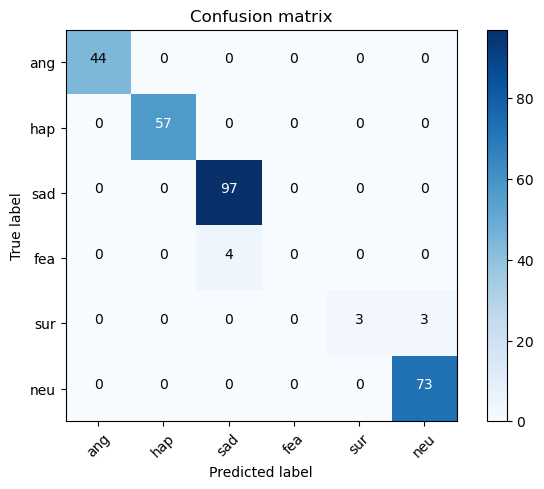

In [64]:
# Load predicted probabilities
with open('pred_probas/combined_rf_classifier.pkl', 'rb') as f:
    rf_pred_probs = pickle.load(f)

with open('pred_probas/combined_xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)
    
with open('pred_probas/combined_svc_classifier_model.pkl', 'rb') as f:
    svc_preds = pickle.load(f)
    
with open('pred_probas/combined_mnb_classifier.pkl', 'rb') as f:
    mnb_pred_probs = pickle.load(f)
    
with open('pred_probas/combined_mlp_classifier.pkl', 'rb') as f:
    mlp_pred_probs = pickle.load(f)
    
with open('pred_probas/combined_lr_classifier.pkl', 'rb') as f:
    lr_pred_probs = pickle.load(f)

# with open('pred_probas/combined_lstm_classifier.pkl', 'rb') as f:
#     lstm_pred_probs = pickle.load(f)

# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs +
                       mlp_pred_probs +
                       rf_pred_probs +
                       mnb_pred_probs +
                       lr_pred_probs)/5.0
# Show metrics
display_results(y_test, ensemble_pred_probs)